# 台指期 CTA 回測框架
* 作者：TMBA 22屆負責人 江祐宏
* 如果有發現寫錯的地方請跟我聯繫！

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')

## 資料整理
1. 合併 Date, Time
2. resample的bug?
    * 交易時間需整除，不然最後一根K看的長度會不一樣 => 1m, 3m, 5m, 10m, 15m, 30m, 60m, 1D
    * reample 1H，通常是從00:00記錄到00:00
    * resample後，沒有交易的時段會有NAN
    * 如果用K棒數來數分K：
        * 有時候夜盤沒交易的時段沒有值，會算錯根數
        * 結算日早盤交易時間少15分鐘，會算到夜盤
    * resample時間前歸後歸、開區間/閉區間的問題
3. 台指期特殊處理
    * 台指期通常慣用結束時間紀錄分K (幣圈是使用開始時間)
    * 2017-5開始有夜盤
    * 分成日盤、日夜盤兩種交易時間
    * 結算日早盤交易時間少15分鐘
    * 每月第三個禮拜三為結算日
    * 交易時段：
        * 日盤：8:46~13:45
        * 夜盤：15:01~5:00

In [2]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [3]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df.head(3)

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8


### 觀察資料

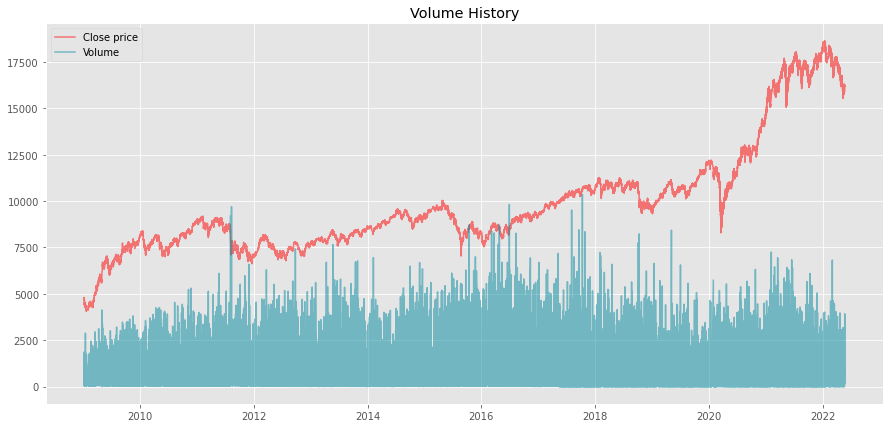

In [4]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History');

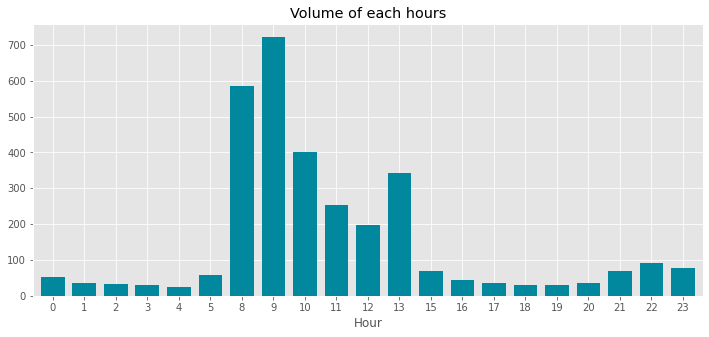

In [5]:
data = df[(df.index >= '2017-05-01 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

### reample

In [6]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='right').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='right').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='right').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='right').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='right').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
2009-01-05 09:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 10:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 11:45:00,4732.0,4733.0,4634.0,4670.0,25172
2009-01-05 12:45:00,4672.0,4688.0,4636.0,4680.0,13241
2009-01-05 13:45:00,4680.0,4698.0,4656.0,4670.0,16247


In [7]:
rule = '60T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='right').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='right').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='right').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='right').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='right').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head()

,open,high,low,close,volume
2017-05-15 16:00:00,10023.0,10034.0,10020.0,10033.0,925
2017-05-15 17:00:00,10032.0,10032.0,10028.0,10030.0,300
2017-05-15 18:00:00,10030.0,10030.0,10026.0,10027.0,137
2017-05-15 19:00:00,10026.0,10028.0,10025.0,10027.0,148
2017-05-15 20:00:00,10028.0,10030.0,10028.0,10030.0,40


In [8]:
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
df_Day.head()

,open,high,low,close,volume
2009-01-05 09:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 10:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 11:45:00,4732.0,4733.0,4634.0,4670.0,25172
2009-01-05 12:45:00,4672.0,4688.0,4636.0,4680.0,13241
2009-01-05 13:45:00,4680.0,4698.0,4656.0,4670.0,16247


### 選擇回測資料

In [9]:
# df_Morning['Month'] = df_Morning.index.map(lambda x: x.month)
# df_Morning['Weekday'] = df_Morning.index.map(lambda x: x.weekday)+1
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)

In [10]:
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()

In [11]:
trainData.head(3)

,open,high,low,close,volume,Hour
2011-01-03 09:45:00,9000.0,9029.0,8995.0,9005.0,20508,9
2011-01-03 10:45:00,9005.0,9014.0,8997.0,9011.0,9022,10
2011-01-03 11:45:00,9010.0,9030.0,9010.0,9023.0,12537,11


In [12]:
testData.tail(3)

,open,high,low,close,volume,Hour
2022-05-20 11:45:00,16104.0,16140.0,16104.0,16134.0,12993,11
2022-05-20 12:45:00,16134.0,16140.0,16113.0,16128.0,7654,12
2022-05-20 13:45:00,16129.0,16145.0,16110.0,16135.0,12758,13


### 取得結算日資料
* https://www.taifex.com.tw/cht/5/futIndxFSP

In [13]:
settlementDate_ = pd.read_csv('settlementDate.csv')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [14]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [15]:
len(list(settlementDate_[bool_]['futures']))

156

In [16]:
12*12 + 5 + 7

156

In [17]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [18]:
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [19]:
settlementDate[-5:]

[datetime.date(2009, 12, 16),
 datetime.date(2009, 11, 18),
 datetime.date(2009, 10, 21),
 datetime.date(2009, 9, 16),
 datetime.date(2009, 8, 19)]

## 回測架構
* 換月轉倉：結算日當天直接平倉
* 進場限制：結算日當天不進場
* 報酬計算：200 * 點數
* 手續費+滑價：單邊 600元

In [20]:
fund = 1000000
feePaid = 600
length = 15
NumStd = 1.5
K = 0.04

# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=length, center=False).mean()
trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']

trainData.tail(3)

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine
2019-12-30 11:45:00,12096.0,12108.0,12089.0,12104.0,6348,11,12057.533333,48.029554,12129.577665,11985.489002
2019-12-30 12:45:00,12103.0,12110.0,12099.0,12107.0,3898,12,12064.600000,46.902330,12134.953495,11994.246505
2019-12-30 13:45:00,12108.0,12109.0,12065.0,12069.0,17832,13,12067.866667,45.251467,12135.743867,11999.989467


In [21]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

                       profit  profitfee
2011-01-03 09:45:00       0.0        0.0
2011-01-03 10:45:00       0.0        0.0
2011-01-03 11:45:00       0.0        0.0
2011-01-03 12:45:00       0.0        0.0
2011-01-03 13:45:00       0.0        0.0
...                       ...        ...
2019-12-30 09:45:00  637000.0    92200.0
2019-12-30 10:45:00  640800.0    96000.0
2019-12-30 11:45:00  638000.0    93200.0
2019-12-30 12:45:00  639400.0    94600.0
2019-12-30 13:45:00  640400.0    94400.0

[11050 rows x 2 columns]


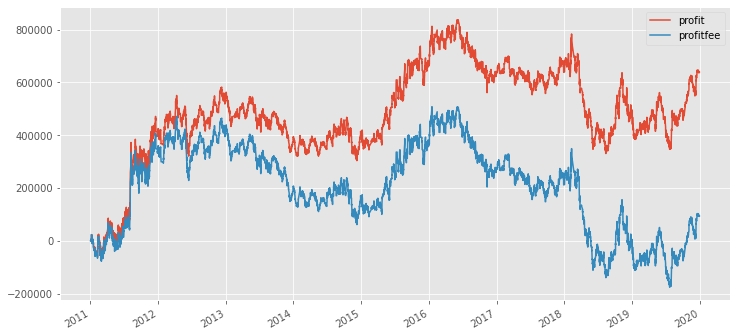

In [22]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i,3] > df_arr[i,8]
    entrySellShort = df_arr[i,3] < df_arr[i,9]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i,3] <= df_arr[i,9]
    exitBuyToCover = df_arr[i,3] >= df_arr[i,8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));